In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from pymongo import MongoClient
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from nltk.stem.snowball import EnglishStemmer
from p4utils import *
%matplotlib inline

In [2]:
np.random.seed(123)

Load contest CSV files to local MongoDB database. See p4utils for details.

I chose to begin at contest 561, since NEXT ML was experimenting with several different algorithms before settling on KLUCB, and I wanted to make sure caption scores were comparable. Also, ~100 contests seemed like a pretty nice round number.

In [ ]:
for contest in range(561, 662):
    csv_to_mongo(contest, "KLUCB")

Just for fun, let's see how many people submitted the ["Christ, what an asshole" meme](https://www.theatlantic.com/notes/2015/09/a-new-universal-new-yorker-cartoon-caption-id-like-to-add-you-to-my-professional-network-linkedin/406783/).

In [5]:
regex_caption_search("Christ, what an asshole")

[{'caption': 'Christ, what an asshole.',
  'contest': 568,
  'count': 50,
  'funny': 4,
  'precision': 0.08081220356417686,
  'rank': 1152,
  'score': 1.2,
  'somewhat_funny': 2,
  'unfunny': 44},
 {'caption': 'Christ, what an asshole.',
  'contest': 574,
  'count': 42,
  'funny': 0,
  'precision': 0.045843796413450766,
  'rank': 2671,
  'score': 1.0952380952380953,
  'somewhat_funny': 4,
  'unfunny': 38},
 {'caption': 'Christ, what an asshole.',
  'contest': 612,
  'count': 50,
  'funny': 3,
  'precision': 0.07559289460184544,
  'rank': 5988,
  'score': 1.2,
  'somewhat_funny': 4,
  'unfunny': 43},
 {'caption': 'Christ, what an asshole.',
  'contest': 619,
  'count': 110,
  'funny': 8,
  'precision': 0.056491554915612675,
  'rank': 882,
  'score': 1.2818181818181817,
  'somewhat_funny': 15,
  'unfunny': 87},
 {'caption': 'Christ, what an asshole.',
  'contest': 623,
  'count': 83,
  'funny': 1,
  'precision': 0.04364365530634865,
  'rank': 3288,
  'score': 1.1566265060240963,
  'somew

Just six!

`load_captions()` connects to the local MongoDB and loads everything to a pandas dataframe, dropping three contests that I identified as duplicates during EDA.

In [3]:
cdb = load_captions()
cdb.head()

,caption,contest,count,funny,precision,rank,score,somewhat_funny,unfunny
0,"And lastly Father, I bit the mailman",561,3814,1134,0.013470,1,1.890928,1130,1550
1,Tell me about it. It's been a week since I lic...,561,3517,962,0.013647,2,1.877168,1161,1394
2,Can you hear me now?,561,5254,1379,0.011044,3,1.866388,1794,2081
3,Just let go of the stick and this will all be ...,561,3140,735,0.014010,4,1.819427,1103,1302
4,And you thought the cat couldn't open the supe...,561,4199,981,0.012280,5,1.790188,1356,1862


Let's stem our captions in preparation for vectorization.

Since there are multiple cartoons involving dogs and also multiple ones involving hot dogs, we don't want to get our wires crossed.

In [4]:
cdb['caption'] = cdb['caption'].replace("[Hh]ot dog", "hotdog", regex=True)
stemmer = EnglishStemmer()
cdb['stemmed']=[' '.join([stemmer.stem(word) for word in text.split(' ')]) for text in cdb['caption']]

Let's use max_df to get a domain-specific list of stop words. After some tweaking, 0.01 seemed like it turned up a pretty good list.

In [5]:
cv = CountVectorizer(max_df=0.01)
captions_vec = cv.fit_transform(cdb['stemmed'])

In [6]:
stop_words = cv.stop_words_
stop_words

{'about',
 'again',
 'all',
 'alway',
 'am',
 'an',
 'and',
 'are',
 'as',
 'ask',
 'at',
 'back',
 'be',
 'been',
 'better',
 'but',
 'by',
 'call',
 'can',
 'come',
 'could',
 'day',
 'did',
 'didn',
 'do',
 'dog',
 'don',
 'down',
 'feel',
 'first',
 'for',
 'from',
 'get',
 'give',
 'go',
 'good',
 'got',
 'had',
 'has',
 'have',
 'he',
 'here',
 'him',
 'his',
 'how',
 'if',
 'in',
 'is',
 'it',
 'just',
 'keep',
 'know',
 'last',
 'let',
 'like',
 'littl',
 'll',
 'look',
 'make',
 'me',
 'more',
 'my',
 'need',
 'never',
 'new',
 'next',
 'no',
 'not',
 'now',
 'of',
 'off',
 'on',
 'one',
 'onli',
 'or',
 'our',
 'out',
 'over',
 'realli',
 'right',
 'said',
 'say',
 'see',
 'should',
 'so',
 'some',
 'still',
 'sure',
 'take',
 'tell',
 'than',
 'that',
 'the',
 'them',
 'there',
 'these',
 'they',
 'thing',
 'think',
 'this',
 'thought',
 'time',
 'to',
 'told',
 'too',
 'tri',
 'up',
 'us',
 'use',
 'want',
 'was',
 'way',
 'we',
 'well',
 'were',
 'what',
 'when',
 'whi',
 

Hold on, there are a couple of meaningful words in there I want to keep..

In [7]:
keep_words = ['dog', 'work']

for word in keep_words:
    stop_words.remove(word)

I tried some topic modeling using caption as the primary document, with mediocre results. Instead, let's concatenate all our captions by our 98 contests.

In [8]:
contest_db = cdb.groupby('contest')['stemmed'].apply(lambda x: " ".join(x))

Tf-idf was more effective than count vectorizer. This makes sense, since the contests had wildly varying numbers of entries and therefore lengths. We can use our stop words list from earlier.

In [9]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2)
contest_vec = tfidf.fit_transform(contest_db)

I tried various dimensionality reducers with various numbers of clusters. After much trial and error, NMF with 20 components delivered pretty nice looking results.

In [10]:
svd = TruncatedSVD(25)
svd.fit(contest_vec)

In [11]:
lda = LatentDirichletAllocation(8)
lda.fit(contest_vec)

In [12]:
nmf = NMF(20)
nmf.fit(contest_vec)

In [13]:
display_topics(nmf, tfidf.get_feature_names(), 10)


Topic  0
work, desk, sword, bed, stock, dummi, stocks, job, ceo, sleep

Topic  1
fish, water, bait, drink, swim, lure, worm, catch, fly, bird

Topic  2
subway, rat, train, wait, grill, sandwich, burger, railroad, medium, express

Topic  3
dog, kite, bark, beam, dogs, cone, vacuum, woof, leash, lick

Topic  4
art, cave, artist, extinct, paint, tusk, deer, work, framed, portrait

Topic  5
knight, armor, shine, suit, sir, joust, armour, wear, date, rust

Topic  6
piano, play, tune, music, tuner, concerto, sonata, mountain, bach, bumblebee

Topic  7
cake, cook, gluten, books, bake, dough, psst, sugar, chef, file

Topic  8
cat, king, mice, catnip, blinder, throne, whale, litter, mous, royal

Topic  9
death, grim, lunch, reap, scythe, scyth, hey, reaper, kill, thanks

Topic  10
ball, pool, core, beach, bat, life, golf, green, big, cave

Topic  11
chest, weight, snake, boa, news, test, result, burn, mr, heartburn

Topic  12
oppon, global, tide, world, earth, climat, warm, hell, warming, hit


These topics give us some categories to look out for: "fish," "work," "dogs," "knights," etc. 

Weirdly, clustering on the reduced dimensions yielded worse results than doing it on the raw tf-idf vectors. I ended up just rolling with it, and looking at the cartoons themselves to determine how "good" clustering was, instead of relying on topic lists.

In [14]:
def cluster_pipeline(data=None, vectorizer=None, cluster_model=None, dims=None):
    if vectorizer:
        vectors = vectorizer.fit_transform(data)
        vectors = vectors.toarray()
    else:
        vectors = data
    if dims:
        svd = TruncatedSVD(dims)
        vectors = svd.fit_transform(vectors)
    cluster_model.fit(vectors)
    return pd.DataFrame(contest_db).reset_index().join(pd.DataFrame(cluster_model.labels_, columns=["label"]))

In [15]:
tfidf = TfidfVectorizer(stop_words=stop_words, min_df=2)
kmeans = KMeans(n_clusters=8)
dbscan = DBSCAN(eps=1.25)
glom8 = AgglomerativeClustering(n_clusters=8, linkage="ward")
glom11 = AgglomerativeClustering(n_clusters=11, linkage="ward")
optics = OPTICS(xi=0.001)
ms = MeanShift(bandwidth=1.05, cluster_all=False)
spec = SpectralClustering(n_clusters = 21, random_state=123)

clustered = cluster_pipeline(data=contest_db, vectorizer=tfidf, cluster_model=glom11)

For example, agglomerative hierarchical clustering, with 11 clusters, gives us ten usable categories, plus a big "other" category that's basically noise.

In [16]:
clustered['label'].value_counts()

0     52
2     10
5      7
1      6
10     5
9      4
4      4
8      3
3      3
7      2
6      2
Name: label, dtype: int64

Here we can see 'cluster 3' cartoons are all about cats.

Cartoon #566:
Cartoon #579:
Cartoon #640:


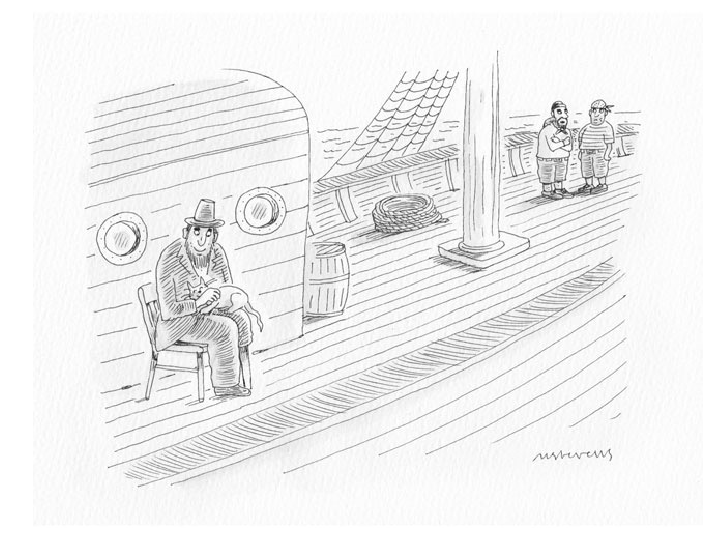

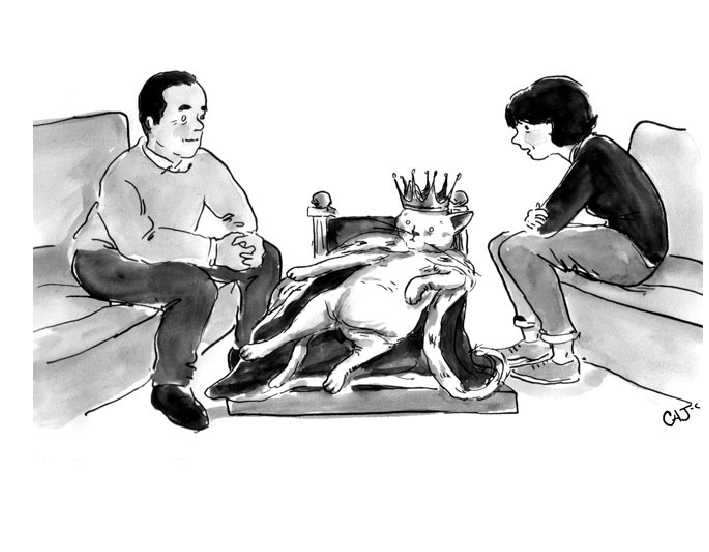

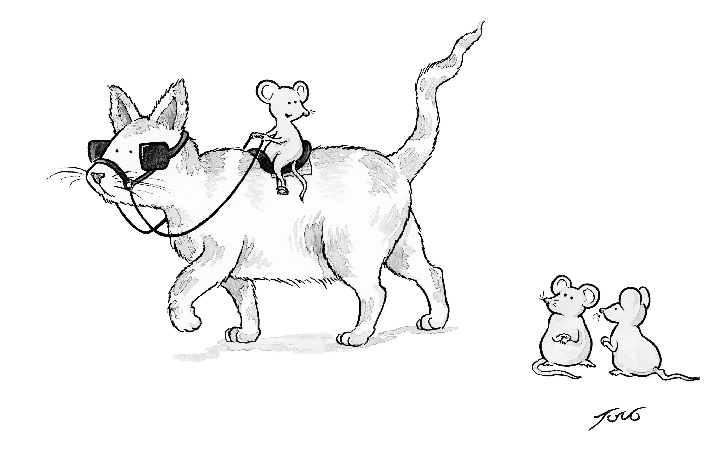

In [17]:
show_labeled_cartoons(clustered, 3)

After quite a bit more trial and error, I took the results of three different clustering techniques - DBSCAN, agglomerative hierarchical, and spectral - and hand-assigned labels to each of the generated clusters for each tool.

In [18]:
#with eps = 1.25
dbscan_labels = { 
    0: "fish / death / party",
    1: "dogs / cats",
    2: "cave / art",
    3: "food",
    4: "subway / rats",
    -1: "NOISE"
}

#with n_clusters = 8
glom8_labels = {
    0: "dogs / cats",
    1: "doctors / food",
    2: "OTHER",
    3: "fish",
    4: "cave / art",
    5: "death / party",
    6: "knights",
    7: "piano",
}

#with n_clusters = 11
glom11_labels = {
    0: "OTHER",
    1: "food / rodents",
    2: "food / doctors",
    3: "cats",
    4: "restaurants",
    5: "death / party",
    6: "knights",
    7: "piano",
    8: "fish",
    9: "cave / art",
    10: "dogs"
}

#with n_clusters = 21
spec_labels = {
    0: "sports / travel",
    1: "hot dogs / sheep",
    2: "work",
    3: "knights",
    4: "dogs",
    5: "cats / hammocks",
    6: "games",
    7: "cave / art",
    8: "doctors",
    9: "misfortune",
    10: "piano",
    11: "death",
    12: "earth / religion",
    13: "fish",
    14: "rats",
    15: "chefs",
    16: "OTHER",
    17: "subway",
    18: "birds / crime",
    19: "restaurants",
    20: "food / doctors"
}

In [19]:
dbscan = DBSCAN(eps=1.25)
glom = AgglomerativeClustering(n_clusters=11, linkage="ward")
spec = SpectralClustering(n_clusters = 21, random_state=123)

clustered = cluster_pipeline(data=contest_db, vectorizer=tfidf, cluster_model=dbscan)
dbscan_label = clustered['label'].map(dbscan_labels)
clustered = cluster_pipeline(data=contest_db, vectorizer=tfidf, cluster_model=glom)
glom_label = clustered['label'].map(glom11_labels)
clustered = cluster_pipeline(data=contest_db, vectorizer=tfidf, cluster_model=spec)
spec_label = clustered['label'].map(spec_labels)

In [20]:
consensus = pd.DataFrame(contest_db).reset_index()\
    .join(dbscan_label)\
    .join(glom_label, rsuffix="_glom")\
    .join(spec_label, rsuffix="_spec")

consensus = consensus.rename({"label": "label_dbscan"}, axis=1)
consensus.head()

,contest,stemmed,label_dbscan,label_glom,label_spec
0,561,"and last father, i bit the mailman tell me abo...",dogs / cats,dogs,dogs
1,562,it could work. we both like worms. one of us s...,fish / death / party,fish,fish
2,563,"listen, i'v got to run. no wonder this gym was...",NOISE,food / doctors,rats
3,564,"they'r will to work nights. yes, i found my la...",NOISE,OTHER,OTHER
4,565,"wow, you are liter a hot mess. no, i recommend...",NOISE,food / rodents,food / doctors


I exported these labels to CSV and hand-coded a "consensus" label for each cartoon, based on the results of these three models as well as my own opinion based on actually looking at the cartoon. Maybe not very scientific, but hey, they're cartoons.

We're going to need this to split apart by category for our RNN training.

In [21]:
consensus[['contest', 'label_dbscan', 'label_glom', 'label_spec']].to_csv("consensus_labels.csv", index=False)

In [ ]:
# some hand coding in csv..

In [22]:
consensus = pd.read_csv("consensus_labels.csv")
consensus.head()

,contest,label_dbscan,label_glom,label_spec,label
0,561,dogs / cats,dogs,dogs,dogs
1,562,fish / death / party,fish,fish,fish
2,563,NOISE,food / doctors,rats,rodents
3,564,NOISE,OTHER,OTHER,work
4,565,NOISE,food / rodents,food / doctors,doctors


In [23]:
consensus['label'].value_counts()

other          25
work            9
food            8
doctors         7
dogs            6
death           5
religion        4
restaurants     4
art             4
subway          3
cats            3
fish            3
games           3
crime           3
birds           3
party           2
piano           2
rodents         2
knights         2
Name: label, dtype: int64

In [24]:
cdb_labels = pd.merge(cdb, consensus[['contest', 'label']], on='contest').drop('stemmed', axis=1)

In [25]:
cdb_labels.head()

,caption,contest,count,funny,precision,rank,score,somewhat_funny,unfunny,label
0,"And lastly Father, I bit the mailman",561,3814,1134,0.013470,1,1.890928,1130,1550,dogs
1,Tell me about it. It's been a week since I lic...,561,3517,962,0.013647,2,1.877168,1161,1394,dogs
2,Can you hear me now?,561,5254,1379,0.011044,3,1.866388,1794,2081,dogs
3,Just let go of the stick and this will all be ...,561,3140,735,0.014010,4,1.819427,1103,1302,dogs
4,And you thought the cat couldn't open the supe...,561,4199,981,0.012280,5,1.790188,1356,1862,dogs


During EDA, I noticed that four of the contests had strange data in the scoring categories - `funny`, `score`, `rank`, etc. I had been previously ignoring this, because I hadn't been using these columns for anything, but for RNN training I wanted to be able to select the top-ranked 1,000 or 1,500 captions per cartoon, in order to speed up training time on the larger categories. Because of these bugs, for these four contests, _all_ of the captions were ranked as being in the "top ten."

To get around this, I assigned fake ranks for these four contests based on their order of appearance.

In [26]:
botched_rank = [591, 592, 599, 600]

cdb_labels['fakerank']=cdb_labels.groupby('contest').cumcount()

for contest in botched_rank:
    mask = (cdb_labels['contest']==contest)
    cdb_labels.loc[mask, 'rank'] = cdb_labels.loc[mask, 'fakerank']
    
cdb_labels = cdb_labels.drop('fakerank', axis=1)

In [27]:
cdb_labels.to_csv("cdb_labels.zip", index=False)

Now let's head over to The Cloud!

_Continue on page `textgenrnn.ipynb`._